<a href="https://colab.research.google.com/github/Reznov9185/node2vecAnalysis/blob/main/node2vecExperiment(on_Cora_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installation of the node2vec library.**

In [1]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-cp37-none-any.whl size=5980 sha256=b95e3053acbf0146df3cf14a88ad0d7ec8ea40270b3742fc9c9534333bb148a5
  Stored in directory: /root/.cache/pip/wheels/34/f4/60/55708b5e797260310451d919c8f898bbd4acd1901367001f20
Successfully built node2vec




> Import Required libraries



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import networkx as nx
import time
%matplotlib inline


Wrapper to use Node2Vec library as we intend

In [3]:
# from nodevectors.embedders import Node2Vec
from node2vec import Node2Vec

class Node2Vec(Node2Vec):
  """
  Parameters
  ----------
  p : float
      p parameter of node2vec
  q : float
      q parameter of node2vec
  d : int
      dimensionality of the embedding vectors
  seed : int
      for similarity in samples for the experiment    
  """
  def __init__(self, graph, p=1, q=1, d=32, seed = 0):
    super().__init__(
                     graph = graph,
                     walk_length=10,
                     p=p,
                     q=q,
                     dimensions =d,
                     quiet = True,
                     seed = seed
                  )

# **Data Processing of Cora citation network and Apply Node2Vec on it**

# Upload cora cites csv

In [4]:
from google.colab import files
uploaded = files.upload()

Saving cora.cites to cora.cites


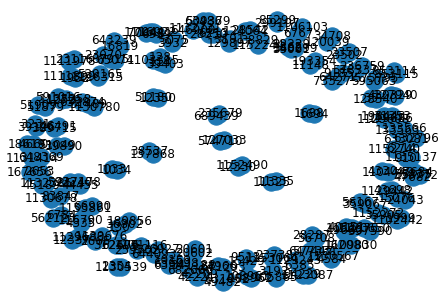

In [9]:
from itertools import combinations
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

# Loading the cora citation network from pandas to Networkx
edgelist = pd.read_csv("cora.cites", sep='\t', header=None, names=["target", "source"])
edgelist = edgelist.sample(frac=1).iloc[0:100]
KG = nx.from_pandas_edgelist(edgelist, "target", "source")

def node2vec_with_hyperparams(p, q, embedder):
  all_possible_edges = list(combinations(KG.nodes(), 2))
  
  # Fit embedding model to the input graph
  # start = time.time()
  n2v_model = Node2Vec(KG, p, q, 4, 1)
  # end = time.time()
  # print(end - start)

  # # Embed nodes
  model = n2v_model.fit(window=10, min_count=1, batch_words=4)

  # Node to vec representation
  K8 =  model.wv.vectors

  # Using different Embedders:
  if embedder == "hadamard": 
    edges_embs = HadamardEmbedder(keyed_vectors=model.wv);
  elif embedder == "average": 
    edges_embs = AverageEmbedder(keyed_vectors=model.wv);
  elif embedder == "weightedL1": 
    edges_embs = WeightedL1Embedder(keyed_vectors=model.wv);
  elif embedder == "weightedL2": 
    edges_embs = WeightedL2Embedder(keyed_vectors=model.wv);
  else: 
    edges_embs = HadamardEmbedder(keyed_vectors=model.wv);                                                            
    
  # From the embedding to dataframe (4-dimensions):
  embeddings = []
  for edge in all_possible_edges:
    edge_found = 0
    if KG.has_edge(edge[0], edge[1]):
      edge_found = 1
    edge_tup = tuple(str(x) for x in edge)
    embeddings.append([edge, edges_embs[edge_tup][0], 
                      edges_embs[edge_tup][1], edges_embs[edge_tup][2],
                      edges_embs[edge_tup][3], edge_found])

  df = pd.DataFrame(embeddings, columns=['node-node', 'a', 'b', 'c', 'd', 'y'])
  df_randomized = df.sample(frac=1)
  df = df_randomized
  df.loc[df.index.isin([155])]
  return df

# **Test Train Split and Sampling functions with some tests**

In [ ]:
from sklearn.neural_network import MLPClassifier

# Test train split method on dataframe based on selected features:
def split_on_dataframe(df):
  features = ['a', 'b', 'c', 'd']
  X = df[features]
  Y = df['y']
  from sklearn.model_selection import train_test_split
  return train_test_split(X, Y)

# Random sample dataframe with the commented out sampling options
def sample_dataframe(df):
  dataframe_edges = df.loc[dataframe['y'] == 1]
  # dataframe_no_edges = df.loc[df['y'] == 0].sample(dataframe_edges.shape[0], 
  #                                                  random_state=1)
  dataframe_no_edges = df.loc[df['y'] == 0]
  data = pd.concat([dataframe_edges, dataframe_no_edges]).sample(frac=1)
  return data

# Test Node2Vec edge-embedding
dataframe = node2vec_with_hyperparams(1, 4, "hadamard")

# Test Classifier and other functionalities
dataframe = node2vec_with_hyperparams(1, 1, "")
X_train, X_test, Y_train, Y_test = split_on_dataframe(sample_dataframe(dataframe))

classifier = 'MLPClassifier'
clf = MLPClassifier(random_state=1, max_iter=390).fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.9927189988623436

# **Function call on multiple dataframes on different Hyperparameters (Naive Approach)**

In [ ]:
from itertools import product
# List of values to use ase hyperparameter p, q
p_q_values = [1, 2, 3, 4]
# List all possible pairs to be used as p,q
combinations_p_q = list(product(p_q_values, p_q_values))
combinations_p_q

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

**Hadamard Embedding Train and Plot**

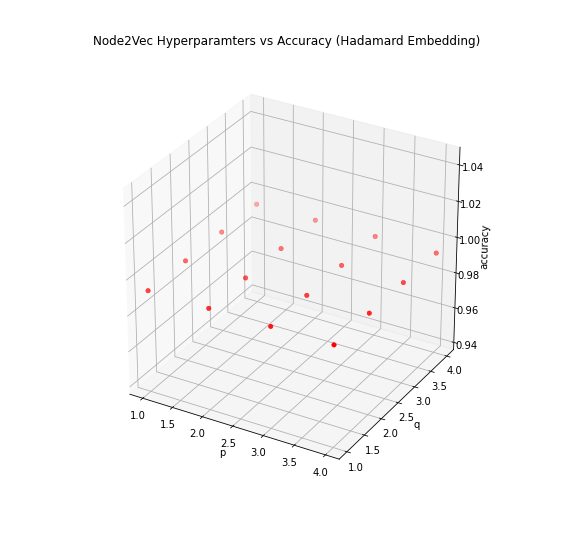

In [ ]:
# Hadamard Embedding
accuracy_data = []

# For each hyperparameter pairs find the accuracy of edge-embeddings:
for i in combinations_p_q:
  dataframe = node2vec_with_hyperparams(i[0], i[1], "hadamard")
  X_train, X_test, Y_train, Y_test = split_on_dataframe(sample_dataframe(dataframe))
  clf = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, Y_train)
  score = clf.score(X_test, Y_test)
  accuracy_data.append([i[0], i[1], score])

# Plotting accuracy data in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.dist = 13
ax.set_title('Node2Vec Hyperparamters vs Accuracy (Hadamard Embedding)')
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('accuracy')

plt_data = np.array(accuracy_data)
ax.scatter3D(plt_data[:,0], plt_data[:,1], plt_data[:,2], c=plt_data[:,2], cmap='hsv',
             linewidth=0.5);

**Average Embedding Train and Plot**

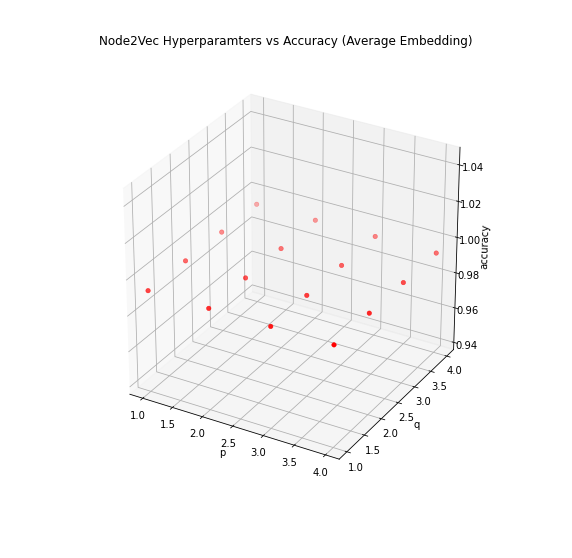

In [ ]:
# Average Embedding
accuracy_data = []

for i in combinations_p_q:
  dataframe = node2vec_with_hyperparams(i[0], i[1], "average")
  X_train, X_test, Y_train, Y_test = split_on_dataframe(sample_dataframe(dataframe))
  clf = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, Y_train)
  score = clf.score(X_test, Y_test)
  accuracy_data.append([i[0], i[1], score])

# Plotting accuracy data in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.dist = 13
ax.set_title('Node2Vec Hyperparamters vs Accuracy (Average Embedding)')
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('accuracy')

plt_data = np.array(accuracy_data)
ax.scatter3D(plt_data[:,0], plt_data[:,1], plt_data[:,2], c=plt_data[:,2], cmap='hsv',
             linewidth=0.5);

**Weighted L1 Embedding Train and Plot**

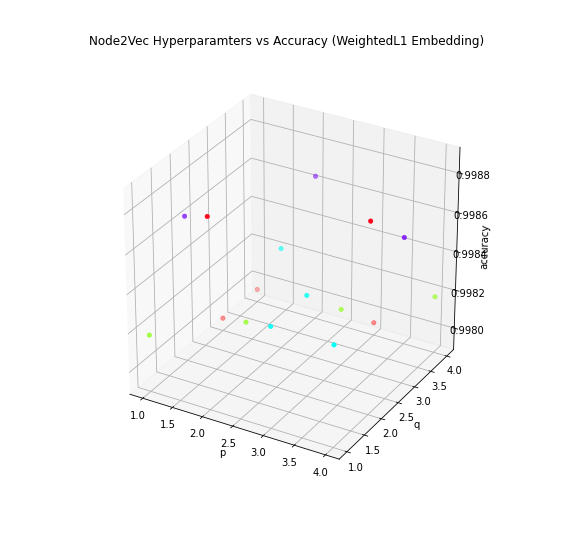

In [ ]:
# WeightedL1 Embedding
accuracy_data = []

for i in combinations_p_q:
  dataframe = node2vec_with_hyperparams(i[0], i[1], "weightedL1")
  X_train, X_test, Y_train, Y_test = split_on_dataframe(sample_dataframe(dataframe))
  clf = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, Y_train)
  score = clf.score(X_test, Y_test)
  accuracy_data.append([i[0], i[1], score])

# Plotting accuracy data in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.dist = 13
ax.set_title('Node2Vec Hyperparamters vs Accuracy (WeightedL1 Embedding)')
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('accuracy')

plt_data = np.array(accuracy_data)
ax.scatter3D(plt_data[:,0], plt_data[:,1], plt_data[:,2], c=plt_data[:,2], cmap='hsv',
             linewidth=0.5);

**Weighted L2 Embedding Train and Plot**

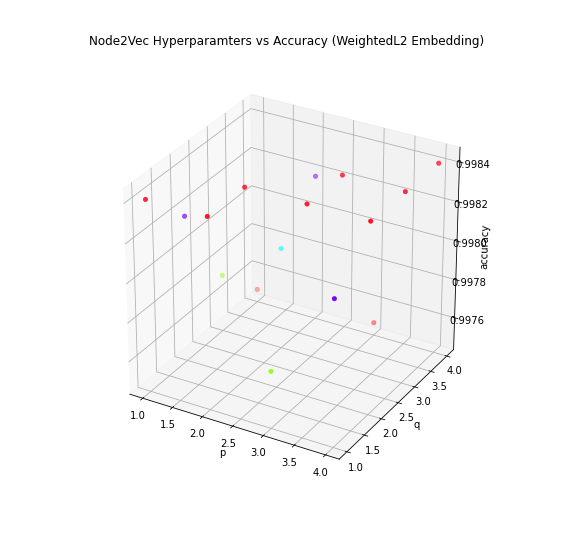

In [ ]:
# WeightedL2 Embedding
accuracy_data = []

for i in combinations_p_q:
  dataframe = node2vec_with_hyperparams(i[0], i[1], "weightedL2")
  X_train, X_test, Y_train, Y_test = split_on_dataframe(sample_dataframe(dataframe))
  clf = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, Y_train)
  score = clf.score(X_test, Y_test)
  accuracy_data.append([i[0], i[1], score])

# Plotting accuracy data in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.dist = 13
ax.set_title('Node2Vec Hyperparamters vs Accuracy (WeightedL2 Embedding)')
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('accuracy')

plt_data = np.array(accuracy_data)
ax.scatter3D(plt_data[:,0], plt_data[:,1], plt_data[:,2], c=plt_data[:,2], cmap='hsv',
             linewidth=0.5);

## **R&D (Not working yet!)**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class EdgeClassifier(BaseEstimator, ClassifierMixin):  
    """An example of classifier"""

    def __init__(self, p=1, q=1):
        """
        Called when initializing the classifier
        """
        self.p = p
        self.q = q


    def fit(self, X=None, y=None):
        print("###########################")
        print(self.q)
        df = node2vec_with_hyperparams(self.p, self.q)
        features = ['a', 'b', 'c']
        X = df[features]
        y = df['y']
        X_train, X_test, Y_train, Y_test = train_test_split(X, y)
        classifier = 'MLPClassifier'
        clf = MLPClassifier(random_state=1, max_iter=390).fit(X, y)
        return clf

    def _meaning(self, x):
        # returns True/False according to fitted classifier
        # notice underscore on the beginning
        return( True if x >= self.treshold_ else False )

    def predict(self, X=None, y=None):
        try:
            getattr(self, "treshold_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return([self._meaning(x) for x in X])

    def score(self, X=None, y=None):
        # counts number of values bigger than mean
        # return(sum(self.predict(X)))
        return clf.score(X, y)

In [ ]:
from sklearn.model_selection import GridSearchCV 

tuned_params = {"p": [1, 2, 3]}

X_test = [i + 3 for i in range(-5, 95, 5)] 

gs = GridSearchCV(EdgeClassifier(), tuned_params)

# for some reason I have to pass y with same shape
# otherwise gridsearch throws an error. Not sure why.
gs.fit(X_test)

gs.best_params_

###########################
1
All possible Edges Count: 561
Positive Samples: 
No. of Nodes: 34
No. of Edges: 78



Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 97.77it/s]


0.18012428283691406


(34, 3)


ValueError: ignored